# Introduction

This lab demonstrates the use of Receiver Operating Characteristic (ROC) metric to evaluate the quality of multiclass classifiers using Scikit-learn library.

# Load and Prepare the Data

Let's start by loading the iris dataset and preparing it for the evaluation of a classifier using the ROC metric.

In [21]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

In [22]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# One-vs-Rest multiclass ROC

The One-vs-the-Rest (OvR) multiclass strategy, also known as one-vs-all, consists in computing a ROC curve per each of the n_classes. In each step, a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk.

One should not confuse the OvR strategy used for the evaluation of multiclass classifiers with the OvR strategy used to train a multiclass classifier by fitting a set of binary classifiers (for instance via the OneVsRestClassifier meta-estimator). The OvR ROC evaluation can be used to scrutinize any kind of classification models irrespectively of how they were trained (see Multiclass and multioutput algorithms).

In this section we use a **LabelBinarizer** to binarize the target by one-hot-encoding in a OvR fashion. This means that the target of shape (**n_samples**,) is mapped to a target of shape (**n_samples**, **n_classes**).

In [23]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(75, 3)

In [24]:
label_binarizer.transform(["virginica"])

array([[0, 0, 1]])

# ROC curve showing a specific class

In the following plot we show the resulting ROC curve when regarding the iris flowers as either “virginica” (class_id=2) or “non-virginica” (the rest).

In [25]:
class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

np.int64(2)

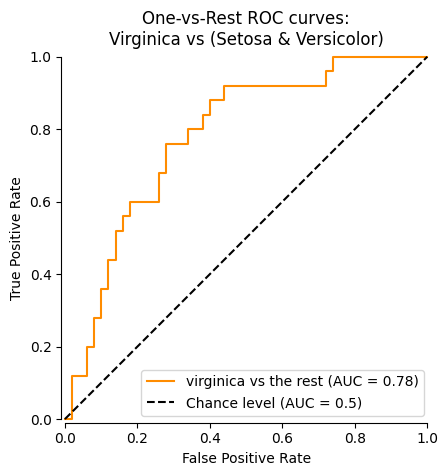

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Create ROC curve display with direct styling kwargs
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",               # ✅ passed directly, not inside `curve_kwargs`
    plot_chance_level=True,
    despine=True,
)

# Set labels and title
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)

plt.show()


# ROC curve using micro-averaged OvR

Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics as follows:

**True Positive Rate (TPR)**:

$$
TPR = \frac{\sum_c TP_c}{\sum_c (TP_c + FN_c)}
$$

**False Positive Rate (FPR)**:

$$
FPR = \frac{\sum_c FP_c}{\sum_c (FP_c + TN_c)}
$$

In [27]:
print(f"y_score:\n{y_score[0:2, :]}")
print()
print(f"y_score.ravel():\n{y_score[0:2, :].ravel()}")

y_score:
[[0.38095776 0.05072909 0.56831315]
 [0.07031555 0.27915668 0.65052777]]

y_score.ravel():
[0.38095776 0.05072909 0.56831315 0.07031555 0.27915668 0.65052777]


In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging, not demonstrated here.

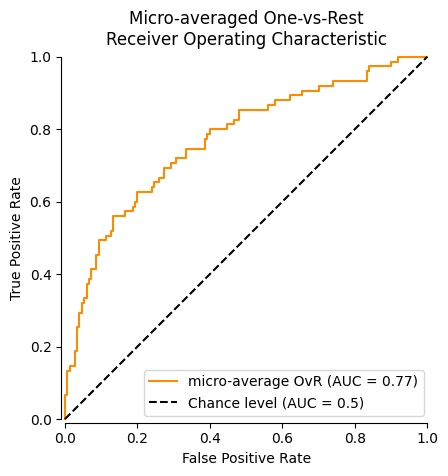

In [28]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Direct styling using keyword arguments (no need for curve_kwargs or manual .set_color)
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",  # ✅ passed directly
    plot_chance_level=True,
    despine=True,
)

# Set labels and title
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

plt.show()


In the case where the main interest is not the plot but the ROC-AUC score itself, we can reproduce the value shown in the plot using roc_auc_score.

In [29]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


This is equivalent to computing the ROC curve with roc_curve and then the area under the curve with auc for the raveled true and predicted classes.

In [30]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


By default, the computation of the ROC curve adds a single point at the maximal false positive rate by using linear interpolation and the McClish correction [Analyzing a portion of the ROC curve Med Decis Making. 1989 Jul-Sep; 9(3):190-5.].

# ROC curve using the OvR macro-average

Obtaining the macro-average requires computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priori. We first aggregate the true/false positive rates per class:



**True Positive Rate (TPR):**

$$
TPR = \frac{1}{C} \sum_c \frac{TP_c}{TP_c + FN_c}
$$

**False Positive Rate (FPR):**

$$
FPR = \frac{1}{C} \sum_c \frac{FP_c}{FP_c + TN_c}
$$

where \( C \) is the total number of classes.
The One-vs-the-Rest (OvR) multiclass strategy consists of computing a ROC curve per each of the **n_classes**. In each step, a given class is regarded as the positive class and the remaining classes are regarded as the negative class as a bulk. In this step, we show how to calculate the ROC curve using the OvR multiclass strategy.

In [31]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.78


This computation is equivalent to simply calling

In [32]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.78


# Plot all OvR ROC curves together

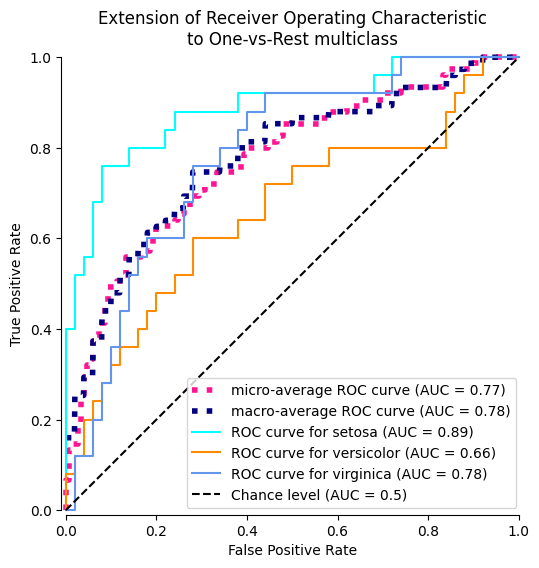

In [33]:
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(6, 6))

# Micro-average ROC
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Macro-average ROC
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Individual class ROC curves
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,  # ✅ pass color directly
        ax=ax,
        plot_chance_level=(class_id == 2),
        despine=True,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

ax.legend(loc="lower right")
plt.show()


# One-vs-One multiclass ROC

The One-vs-One (OvO) multiclass strategy consists in fitting one classifier per class pair. Since it requires to train **n_classes*** * (**n_classes** - 1) / 2 classifiers, this method is usually slower than One-vs-Rest due to its O(**n_classes** ^2) complexity.

In this section, we demonstrate the macro-averaged AUC using the OvO scheme for the 3 possible combinations in the Iris plants dataset: “setosa” vs “versicolor”, “versicolor” vs “virginica” and “virginica” vs “setosa”. Notice that micro-averaging is not defined for the OvO scheme.

# ROC curve using the OvO macro-average

In the OvO scheme, the first step is to identify all possible unique combinations of pairs. The computation of scores is done by treating one of the elements in a given pair as the positive class and the other element as the negative class, then re-computing the score by inversing the roles and taking the mean of both scores.

In [34]:
from itertools import combinations

pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

[(np.str_('setosa'), np.str_('versicolor')), (np.str_('setosa'), np.str_('virginica')), (np.str_('versicolor'), np.str_('virginica'))]


One can also assert that the macro-average we computed “by hand” is equivalent to the implemented average="macro" option of the roc_auc_score function.

In [36]:
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

print(f"Macro-averaged One-vs-One ROC AUC score:\n{macro_roc_auc_ovo:.2f}")

Macro-averaged One-vs-One ROC AUC score:
0.78


# Plot all OvO ROC curves together


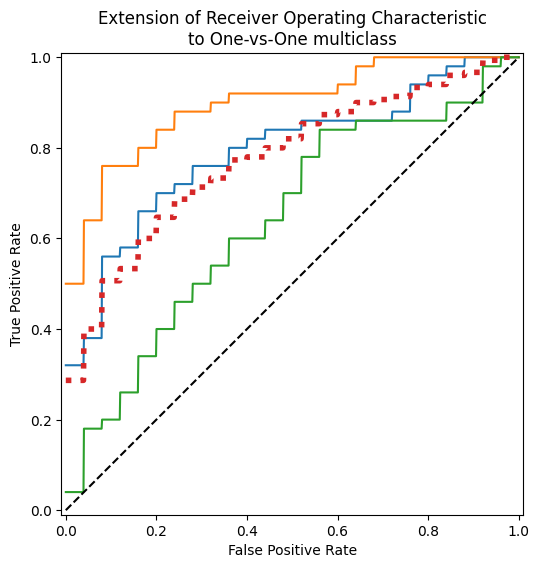

In [37]:
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    ax.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

ax.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
ax.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-One multiclass",
    aspect="equal",
    xlim=(-0.01, 1.01),
    ylim=(-0.01, 1.01),
)

We confirm that the classes “versicolor” and “virginica” are not well identified by a linear classifier. Notice that the “virginica”-vs-the-rest ROC-AUC score (0.77) is between the OvO ROC-AUC scores for “versicolor” vs “virginica” (0.64) and “setosa” vs “virginica” (0.90). Indeed, the OvO strategy gives additional information on the confusion between a pair of classes, at the expense of computational cost when the number of classes is large.

The OvO strategy is recommended if the user is mainly interested in correctly identifying a particular class or subset of classes, whereas evaluating the global performance of a classifier can still be summarized via a given averaging strategy.

When dealing with imbalanced datasets, choosing the appropriate metric based on the business context or problem you are addressing is crucial. It is also essential to select an appropriate averaging method (micro vs. macro) depending on the desired outcome:

- Micro-averaging aggregates metrics across all instances, treating each individual instance equally, regardless of its class. This approach is useful when evaluating overall performance, but note that it can be dominated by the majority class in imbalanced datasets.

- Macro-averaging calculates metrics for each class independently and then averages them, giving equal weight to each class. This is particularly useful when you want under-represented classes to be considered as important as highly populated classes.

# Summary

In this lab, we learned how to evaluate the performance of a multiclass classifier using the ROC curve and ROC AUC score. We demonstrated how to calculate ROC curves using the One-vs-Rest (OvR) and One-vs-One (OvO) multiclass strategies. We also showed how to calculate micro and macro-averaged ROC curves and ROC AUC scores using Scikit-learn.